In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('monthly_softdrink_production.csv',index_col='Date',parse_dates=True)

In [44]:
df.head(1000)

,Production
Date,
2007-01-01,589
2007-02-01,561
2007-03-01,640
2007-04-01,656
2007-05-01,727
...,...
2020-08-01,858
2020-09-01,817
2020-10-01,827


<AxesSubplot:xlabel='Date'>

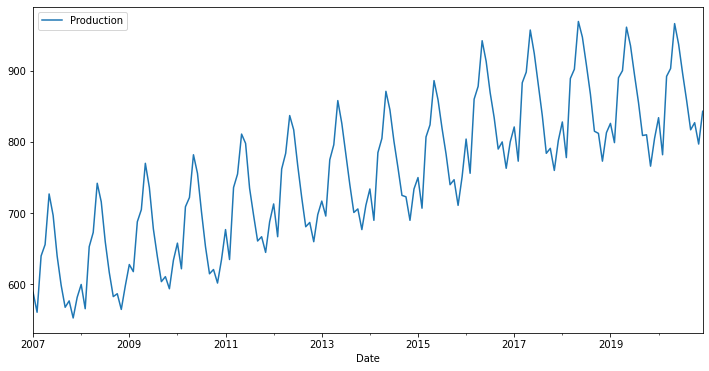

In [13]:
df.plot(figsize=(12,6))

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

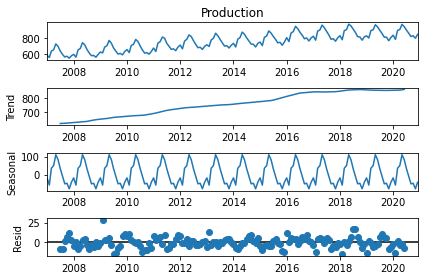

In [15]:
results = seasonal_decompose(df['Production'])
results.plot();

In [16]:
len(df)

168

In [17]:
train = df.iloc[:156]
test = df.iloc[156:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
df.head(),df.tail()

(            Production
 Date                  
 2007-01-01         589
 2007-02-01         561
 2007-03-01         640
 2007-04-01         656
 2007-05-01         727,
             Production
 Date                  
 2020-08-01         858
 2020-09-01         817
 2020-10-01         827
 2020-11-01         797
 2020-12-01         843)

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [22]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [25]:
X.shape

(1, 3, 1)

In [26]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 46s 13ms/step - loss: 0.1134
Epoch 2/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0241
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0187
Epoch 4/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0160
Epoch 5/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0149
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0067
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0052
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 11/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 12/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 13/50
144/144 

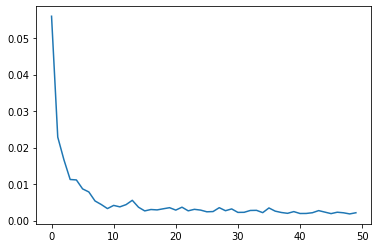

In [31]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [32]:
last_train_batch = scaled_train[-12:]

In [33]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [34]:
model.predict(last_train_batch)

array([[0.74820536]], dtype=float32)

In [35]:
scaled_test[0]

array([0.67548077])

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [37]:
test_predictions

[array([0.74820536], dtype=float32),
 array([0.74469274], dtype=float32),
 array([0.9380922], dtype=float32),
 array([0.994737], dtype=float32),
 array([1.1023871], dtype=float32),
 array([1.06103], dtype=float32),
 array([0.9656608], dtype=float32),
 array([0.8638818], dtype=float32),
 array([0.74957836], dtype=float32),
 array([0.72742385], dtype=float32),
 array([0.6690569], dtype=float32),
 array([0.72527534], dtype=float32)]

In [38]:
test.head()

,Production
Date,
2020-01-01,834
2020-02-01,782
2020-03-01,892
2020-04-01,903
2020-05-01,966


In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
test['Predictions'] = true_predictions

<ipython-input-41-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

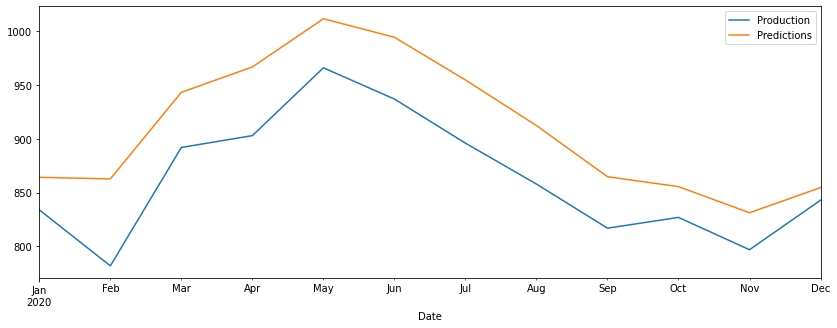

In [42]:
test.plot(figsize=(14,5))

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

50.28096043181706
